[![Fixel Algorithms](https://i.imgur.com/AqKHVZ0.png)](https://fixelalgorithms.gitlab.io/)

# Gaussian Mixture Models (GMM)

> Notebook by:
> - Royi Avital RoyiAvital@fixelalgorithms.com

## Revision History

| Version | Date       | User        |Content / Changes                                                   |
|---------|------------|-------------|--------------------------------------------------------------------|
| 1.0.000 | 13/04/2024 | Royi Avital | First version                                                      |

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/AIProgram/2024_02/0059ClusteringGMM.ipynb)

In [1]:
# Import Packages

# General Tools
import numpy as np
import scipy as sp
import pandas as pd

# Machine Learning
from sklearn.datasets import load_iris, make_blobs
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold

# Miscellaneous
import math
import os
from platform import python_version
import random
import timeit

# Typing
from typing import Callable, Dict, List, Optional, Self, Set, Tuple, Union

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Jupyter
from IPython import get_ipython
from IPython.display import Image
from IPython.display import display
from ipywidgets import Dropdown, FloatSlider, interact, IntSlider, Layout, SelectionSlider
from ipywidgets import interact

## Notations

* <font color='red'>(**?**)</font> Question to answer interactively.
* <font color='blue'>(**!**)</font> Simple task to add code for the notebook.
* <font color='green'>(**@**)</font> Optional / Extra self practice.
* <font color='brown'>(**#**)</font> Note / Useful resource / Food for thought.

Code Notations:

```python
someVar    = 2; #<! Notation for a variable
vVector    = np.random.rand(4) #<! Notation for 1D array
mMatrix    = np.random.rand(4, 3) #<! Notation for 2D array
tTensor    = np.random.rand(4, 3, 2, 3) #<! Notation for nD array (Tensor)
tuTuple    = (1, 2, 3) #<! Notation for a tuple
lList      = [1, 2, 3] #<! Notation for a list
dDict      = {1: 3, 2: 2, 3: 1} #<! Notation for a dictionary
oObj       = MyClass() #<! Notation for an object
dfData     = pd.DataFrame() #<! Notation for a data frame
dsData     = pd.Series() #<! Notation for a series
hObj       = plt.Axes() #<! Notation for an object / handler / function handler
```

### Code Exercise

 - Single line fill

 ```python
 vallToFill = ???
 ```

 - Multi Line to Fill (At least one)

 ```python
 # You need to start writing
 ????
 ```

 - Section to Fill

```python
#===========================Fill This===========================#
# 1. Explanation about what to do.
# !! Remarks to follow / take under consideration.
mX = ???

???
#===============================================================#
```

In [2]:
# Configuration
# %matplotlib inline

seedNum = 512
np.random.seed(seedNum)
random.seed(seedNum)

# Matplotlib default color palette
lMatPltLibclr = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
# sns.set_theme() #>! Apply SeaBorn theme

runInGoogleColab = 'google.colab' in str(get_ipython())

# GMM Warnings
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings('ignore', category = ConvergenceWarning) #<! Suppress GMM convergence warning


In [3]:
# Constants

FIG_SIZE_DEF    = (8, 8)
ELM_SIZE_DEF    = 50
CLASS_COLOR     = ('b', 'r')
EDGE_COLOR      = 'k'
MARKER_SIZE_DEF = 10
LINE_WIDTH_DEF  = 2


In [4]:
# Courses Packages
import sys
sys.path.append('../')
sys.path.append('../../')
sys.path.append('../../../')
from utils.DataVisualization import PlotScatterData


In [5]:
# General Auxiliary Functions

def GenRotMatrix( θ: float ) -> np.ndarray:
    thetaAng = np.radians(θ) #<! Convert Degrees -> Radians
    cosVal, sinVal = np.cos(thetaAng), np.sin(thetaAng)

    mR = np.array([[cosVal, -sinVal], [sinVal, cosVal]])

    return mR


def PlotGmm( mX: np.ndarray, numClusters: int, numIter: int, initMethod: str = 'random', hA: Optional[plt.Axes] = None, figSize: Tuple[int, int] = FIG_SIZE_DEF, markerSize: int = MARKER_SIZE_DEF ) -> plt.Axes:

    if hA is None:
        hF, hA = plt.subplots(figsize = figSize)
    else:
        hF = hA.get_figure()

    oGmm = GaussianMixture(n_components = numClusters, max_iter = numIter, init_params = initMethod, random_state = 0)
    oGmm = oGmm.fit(mX)

    vIdx    = oGmm.predict(mX)
    mMu     = oGmm.means_

    hS = hA.scatter(mX[:, 0], mX[:, 1], s = ELM_SIZE_DEF, c = vIdx, edgecolor = EDGE_COLOR)
    hA.plot(mMu[:,0], mMu[:, 1], '.r', markersize = 20)
    for ii in range(numClusters):
        mC = oGmm.covariances_[ii]
        v, w = np.linalg.eigh(mC)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  #<! Convert to degrees
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        ell = mpl.patches.Ellipse(oGmm.means_[ii, :], v[0], v[1], angle = 180 + angle, color = hS.cmap(ii / (numClusters - 1)))
        ell.set_clip_box(hA.bbox)
        ell.set_alpha(0.5)
        hA.add_artist(ell)
    hA.axis('equal')
    hA.axis([-10, 10, -10, 10])
    hA.set_xlabel('${{x}}_{{1}}$')
    hA.set_ylabel('${{x}}_{{2}}$')
    hA.set_title(f'K-Means Clustering, AIC = {oGmm.aic(mX)}, BIC = {oGmm.bic(mX)}')

    return hA


## Clustering by GMM

This notebook demonstrates the use the GMM for clustering.  
The GMM can be thought as extension to _K-Means_ with soft assignment and support for non equal and non isotropic blobs.  
As the GMM is a combination of Gaussian Distributions its "atom" is the ellipsoid.

* <font color='brown'>(**#**)</font> With some data scaling the K-Means can also support non isotropic data.

In [6]:
# Parameters

# Data Generation
vNumSamples = [50, 150, 500, 100]
mMu         = [[0, 0], [2, 2], [-2.5, -2.5], [-4, 4]]
vClusterStd = [0.1, 1, 2, 1.5]

# Model



## Generate / Load Data

A set of _anisotropic_ blobs.


In [7]:
# Generate Data

mX, vL = make_blobs(n_samples = vNumSamples, n_features = 2, centers = mMu, cluster_std = vClusterStd)
numSamples  = mX.shape[0]

print(f'The features data shape: {mX.shape}')

The features data shape: (800, 2)


* <font color='red'>(**?**)</font> Where are the labels in this case?

### Plot Data

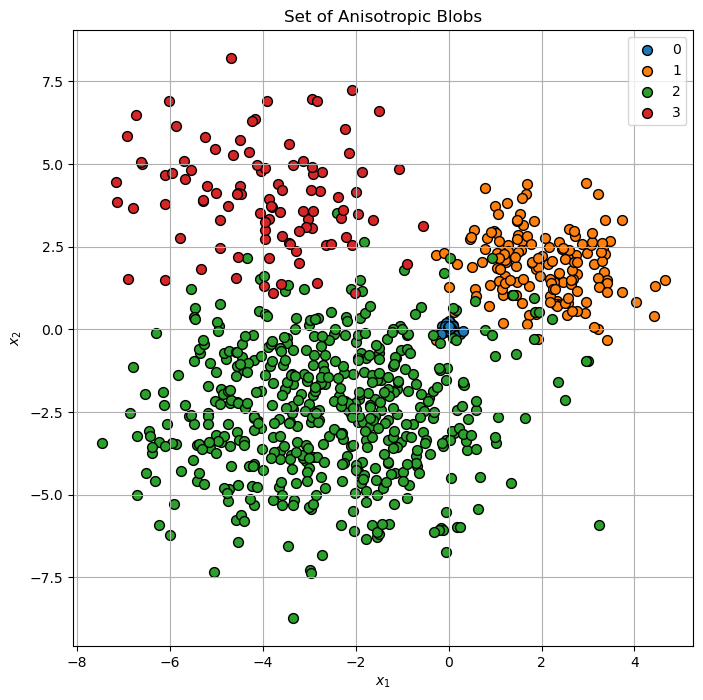

In [8]:
# Plot the Data

hF, hA = plt.subplots(figsize = (8, 8))

hA = PlotScatterData(mX, vL, hA = hA)
hA.set_title('Set of Anisotropic Blobs')

plt.show()


* <font color='red'>(**?**)</font> Are there points which are confusing in their labeling?

## Cluster Data by Expectation Maximization (EM) for the GMM Model

1. Step I:  
Assume fixed parameters $\left\{ w_{k}\right\}$, $\left\{ \boldsymbol{\mu}_{k}\right\}$ and $\left\{ \boldsymbol{\Sigma}_{k}\right\}$.  
Compute the probability that $\boldsymbol{x}_{i}$ belong to $\mathcal{D}_{k}$:

$$
P_{X_{i}}\left(k\right)=\frac{w_{k}\mathcal{N}\left(\boldsymbol{x}_{i};\boldsymbol{\mu}_{k},\boldsymbol{\Sigma}_{k}\right)}{\sum_{k'=1}^{K}w_{k'}\mathcal{N}\left(\boldsymbol{x}_{i};\boldsymbol{\mu}_{k'},\boldsymbol{\Sigma}_{k'}\right)}
$$

2. Step II: 
Assume fixed probabilities $P_{X_{i}}\left(k\right)$.  
Update the parameters $\left\{ w_{k}\right\}$, $\left\{ \boldsymbol{\mu}_{k}\right\}$ and $\left\{ \boldsymbol{\Sigma}_{k}\right\}$ by:

$$
N_{k}:=\sum_{i=1}^{N}P_{X_{i}}\left(k\right),
$$

$$
w_{k}=\frac{N_{k}}{N},
$$

$$
\boldsymbol{\mu}_{k}=\frac{1}{N}\sum_{i=1}^{N}P_{X_{i}}\left(k\right)\boldsymbol{x}_{i},
$$

$$
\boldsymbol{\Sigma}_{k}=\frac{1}{N_{k}}\sum_{i=1}^{N}P_{X_{i}}\left(k\right)\left(\boldsymbol{x}_{i}-\boldsymbol{\mu}_{k}\right)\left(\boldsymbol{x}_{i}-\boldsymbol{\mu}_{k}\right)^{T}
$$


3. Step III:  
Check for convergence (Change in assignments / location of the center). If not, go to _Step I_.


* <font color='brown'>(**#**)</font> The GMM is implemented by the [`GaussianMixture`](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html) class in SciKit Learn.

* <font color='red'>(**?**)</font> Think of the convergence check options. Think of the cases of large data set vs. small data set.
* <font color='brown'>(**#**)</font> A useful initialization for the GMM is using few _K-Means_ iterations.

In [9]:
# Visualization Wrapper Function
hPlotGmm = lambda numClusters, numIter, initMethod: PlotGmm(mX, numClusters = numClusters, numIter = numIter, initMethod = initMethod, figSize = (7, 7))

In [10]:
# Interactive Visualization

numClustersSlider = IntSlider(min = 2, max = 10, step = 1, value = 3, layout = Layout(width = '30%'))
numIterSlider = IntSlider(min = 1, max = 100, step = 1, value = 1, layout = Layout(width = '30%'))
if runInGoogleColab:
    initMethodDropdown = Dropdown(description = 'Initialization Method', options = [('K-Means', 'kmeans')], value = 'kmeans')
else:
    initMethodDropdown = Dropdown(description = 'Initialization Method', options = [('K-Means', 'kmeans'), ('Random', 'random_from_data'), ('K-Means++', 'k-means++')], value = 'random_from_data')
interact(hPlotGmm, numClusters = numClustersSlider, numIter = numIterSlider, initMethod = initMethodDropdown)

plt.show()

interactive(children=(IntSlider(value=3, description='numClusters', layout=Layout(width='30%'), max=10, min=2)…

### Optimizing the Number of Clusters

In order to set the number of clusters automatically one can use:

 - The _Elbow Method_ of the K-Means.
 - The _Silhouette Score_.
 - The [Akaike Information Criterion](https://en.wikipedia.org/wiki/Akaike_information_criterion) (AIC) and [Bayesian Information Criterion](https://en.wikipedia.org/wiki/Bayesian_information_criterion) (BIC) measures.

The AIC and BIC measures the performance of the model in prediction vs. its complexity.  
They try to find the optimal point between model complexity and performance (Bias <-> Variance / Underfit <-> Overfit).

The [`GaussianMixture`](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html) has the `aic()` and `bic()` methods.

* <font color='brown'>(**#**)</font> One may use the AIC and BIC in the K-Means context as well.

In [11]:
# Analysis of Performance by AIC and BIC
lK = list(range(1, 10))
numK = len(lK)
vAic = np.full(shape = numK, fill_value = np.nan)
vBic = np.full(shape = numK, fill_value = np.nan)

for ii, valK in enumerate(lK):
    oGmm = GaussianMixture(n_components = valK, max_iter = 2_000, init_params = 'kmeans', random_state = 0)
    oGmm = oGmm.fit(mX)
    vAic[ii] = oGmm.aic(mX)
    vBic[ii] = oGmm.bic(mX)

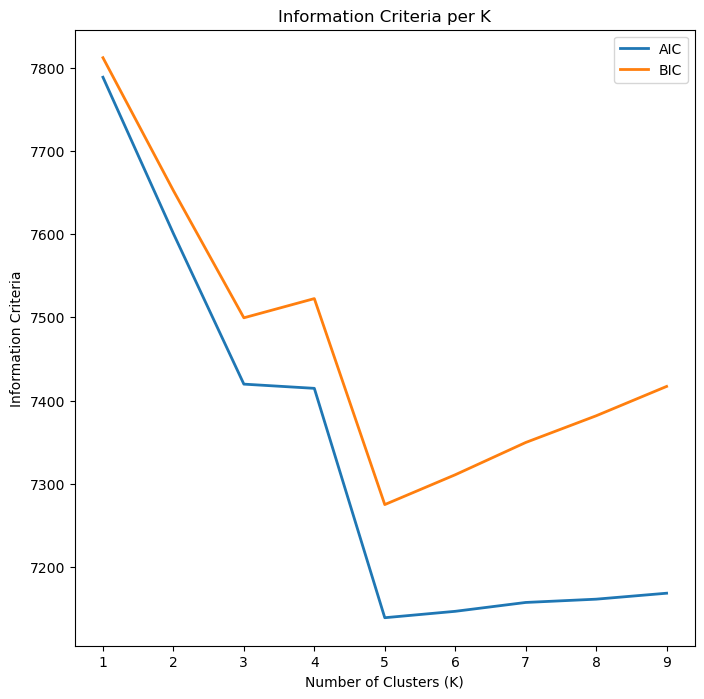

In [12]:
# Plot Results

hF, hA = plt.subplots(figsize = (8, 8))
hA.plot(lK, vAic, lw = 2, label = 'AIC')
hA.plot(lK, vBic, lw = 2, label = 'BIC')
hA.set_xlabel('Number of Clusters (K)')
hA.set_ylabel('Information Criteria')
hA.set_title('Information Criteria per K')
hA.legend();

* <font color='brown'>(**#**)</font> The optimal value is the minimum which is the point where the performance per complexity is maximized.
* <font color='brown'>(**#**)</font> In general, it might be best to use AIC and BIC together in model selection.  
  The main differences between the two is that BIC penalizes model complexity more heavily. If BIC points to a three clusters model and AIC points to a five clusters model, it makes sense to select from models with 3, 4 and 5 latent classes.
* <font color='brown'>(**#**)</font> In cases there is no minimum point, it is useful to look at the maximum gradient (Similar to the _Elbow Trick_). See [Gaussian Mixture Model Clusterization: How to Select the Number of Components](https://scribe.rip/553bef45f6e4).
* <font color='brown'>(**#**)</font> Additional readings: [GMM Algorithm](http://ethen8181.github.io/machine-learning/clustering/GMM/GMM.html), [Choosing between AIC and BIC](https://stats.stackexchange.com/questions/577).

## Different Covariance Matrix Assumptions

We'll watch the effect of the covariance matrix on the results.

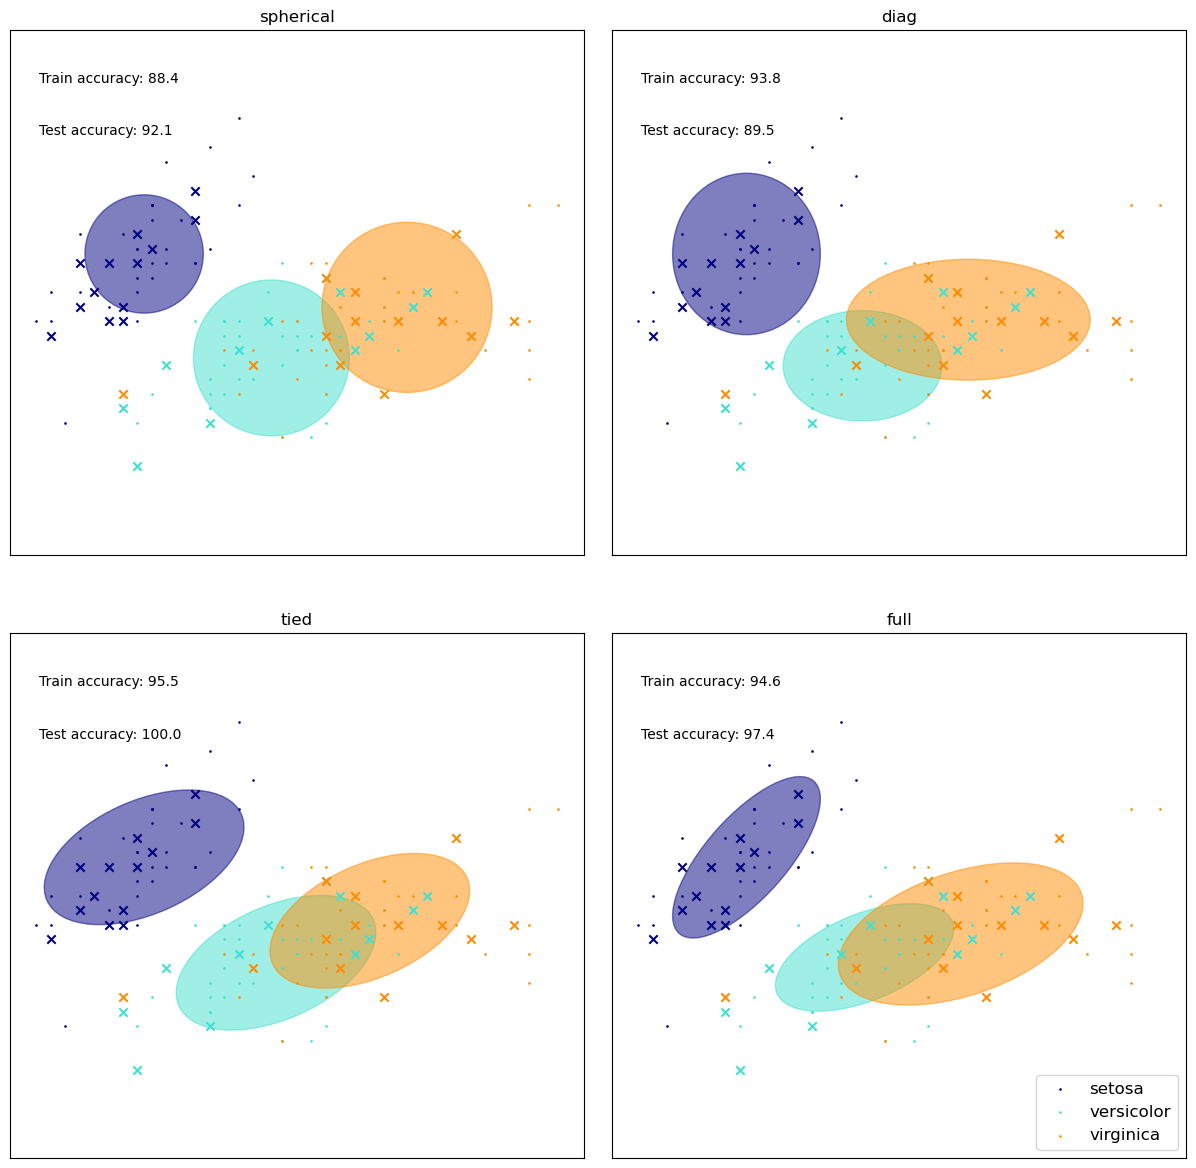

In [13]:
# From SciKit Learn

colors = ["navy", "turquoise", "darkorange"]


def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == "full":
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == "tied":
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == "diag":
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == "spherical":
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        ell = mpl.patches.Ellipse(
            gmm.means_[n, :2], v[0], v[1], angle = 180 + angle, color=color
        )
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect("equal", "datalim")


iris = load_iris()

# Break up the dataset into non-overlapping training (75%) and testing
# (25%) sets.
skf = StratifiedKFold(n_splits=4)
# Only take the first fold.
train_index, test_index = next(iter(skf.split(iris.data, iris.target)))


X_train = iris.data[train_index]
y_train = iris.target[train_index]
X_test = iris.data[test_index]
y_test = iris.target[test_index]

n_classes = len(np.unique(y_train))

# Try GMMs using different types of covariances.
estimators = {
    cov_type: GaussianMixture(
        n_components=n_classes, covariance_type=cov_type, max_iter=20, random_state=0
    )
    for cov_type in ["spherical", "diag", "tied", "full"]
}

n_estimators = len(estimators)

plt.figure(figsize=(12, 12))
plt.subplots_adjust(
    bottom=0.01, top=0.95, hspace=0.15, wspace=0.05, left=0.01, right=0.99
)


for index, (name, estimator) in enumerate(estimators.items()):
    # Since we have class labels for the training data, we can
    # initialize the GMM parameters in a supervised manner.
    estimator.means_init = np.array(
        [X_train[y_train == i].mean(axis=0) for i in range(n_classes)]
    )

    # Train the other parameters using the EM algorithm.
    estimator.fit(X_train)

    h = plt.subplot(2, n_estimators // 2, index + 1)
    make_ellipses(estimator, h)

    for n, color in enumerate(colors):
        data = iris.data[iris.target == n]
        plt.scatter(
            data[:, 0], data[:, 1], s=0.8, color=color, label=iris.target_names[n]
        )
    # Plot the test data with crosses
    for n, color in enumerate(colors):
        data = X_test[y_test == n]
        plt.scatter(data[:, 0], data[:, 1], marker="x", color=color)

    y_train_pred = estimator.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
    plt.text(0.05, 0.9, "Train accuracy: %.1f" % train_accuracy, transform=h.transAxes)

    y_test_pred = estimator.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
    plt.text(0.05, 0.8, "Test accuracy: %.1f" % test_accuracy, transform=h.transAxes)

    plt.xticks(())
    plt.yticks(())
    plt.title(name)

plt.legend(scatterpoints = 1, loc = "lower right", prop = dict(size = 12))


plt.show()